#### 작업 노트북 
- feature 정리 
- 데이터 전처리
- 모델링
- 학습 및 추론
- 제품별 추천 결과 테이블

In [ ]:
%pip install pandas
%pip install scikit-learn
%pip install sqlalchemy
%pip install pymysql
%pip install konlpy
%pip install matplotlib
%pip install gensim
%pip install numpy==1.26.4

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import warnings
import re 
from model.bow import BagOfWords
from model.tfidf import TfIdf
import yaml
import matplotlib.pyplot as plt

from utils.preprocessing import *

warnings.filterwarnings("ignore")

#### Configuration
- 추천 서비스 생성을 위해서 필요한 설정값들을 세팅합니다.

In [2]:
# config
with open('configs/database.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
from utils.query_service import QueryService
query_service = QueryService(cfg['mysql'])

#### Data Import
- 사용할 데이터를 mysql에서 가져옵니다. 

In [4]:
query_service.query_to_pandas_df('Show tables')

,Tables_in_bakery
0,board_preference_statistic
1,board_statistic
2,food_survey
3,image
4,member
5,member_preference
6,notice
7,preference
8,product
9,product_board


In [5]:
PRODUCT_BOARD_SQL = """
SELECT id
, store_id
, title
, price
, is_soldout
, view 
FROM product_board
"""
product_board = query_service.query_to_pandas_df(PRODUCT_BOARD_SQL)

In [6]:
PRODUCT_SQL = """
SELECT id
, product_board_id
, title as option
, price as option_price
, category
, gluten_free_tag
, high_protein_tag
, sugar_free_tag
, vegan_tag
, ketogenic_tag
FROM product
"""
product = query_service.query_to_pandas_df(PRODUCT_SQL)

In [7]:
REVIEW_SQL = """
SELECT board_id
, badge_taste
, badge_brix
, badge_texture
, rate
, content
FROM review
"""
review = query_service.query_to_pandas_df(REVIEW_SQL)
review = review.drop_duplicates(subset=['board_id', 'content'], keep='first')

In [8]:
BOARD_STAT_SQL = """
SELECT board_id
, board_review_grade
, board_view_count
, board_review_count
, board_wish_count 
FROM board_statistic
"""
board_stat = query_service.query_to_pandas_df(BOARD_STAT_SQL)

In [9]:
# board_id가 각 preference_type마다 얼만큼의 preference_score를 갖는지
# 아직 신뢰성있는 데이터로 보이진 않음 (샘플이 적고 score의 분산이 너무 큼)
BOARD_PREFERENCE_STAT_SQL = """
SELECT board_id
, preference_score
, preference_type
, preference_weight
FROM board_preference_statistic
ORDER BY board_id
"""
board_preference_stat = query_service.query_to_pandas_df(BOARD_PREFERENCE_STAT_SQL)

#### Preprocessing

1. Product + Product board 데이터 기반 유사도 테이블
2. Coverage 평가 방법 수행 및 시각화
3. 후처리 고려하기

In [10]:
product.head()

,id,product_board_id,option,option_price,category,gluten_free_tag,high_protein_tag,sugar_free_tag,vegan_tag,ketogenic_tag
0,1,1,필수상품 없음,3800,CAKE,1,0,0,0,0
1,2,2,드리,5000,COOKIE,1,0,0,1,0
2,3,2,초코코코넛(넛프리),5000,COOKIE,1,0,0,1,0
3,4,2,한라봉얼그레이,5000,COOKIE,1,0,0,1,0
4,5,2,바나나피칸(제로슈가/노오일/노솔트),5000,COOKIE,1,0,0,1,0


In [11]:
product_board.head()

,id,store_id,title,price,is_soldout,view
0,1,1,냥빵 파운드 저탄수 대체당 제로 빵 글루텐프리 건강빵 비건,3800,0,0
1,2,2,비건 유기농 쌀 & 기장쌀 잡곡 비스코티 5종 미앤드리 글루텐프리,5000,1,0
2,3,3,비건이레 비건케이크 글루텐프리 떠먹는케이크 얼그레이아몬드베린느 GF,7500,0,0
3,4,4,프로넛 무설탕 자일리톨 캔디 레몬 선물 사탕 금연 양치 아이간식 어린이집,2800,0,0
4,5,5,꾸디 비건쿠키 (르뱅쿠키 수제쿠키),4200,0,0


In [12]:
review.head()

,board_id,badge_taste,badge_brix,badge_texture,rate,content
0,178,GOOD,NULL,NULL,3.0,일단 크기는 굉장히 작아요 성분이 괜찮아서 구매했는데 저는 그냥 한번 먹어본걸로 만...
1,178,NULL,NULL,NULL,5.0,좋은 빵 많이 만들어주세요
2,178,NULL,NULL,NULL,5.0,건강한 상품 잘 먹겠습니다
3,178,GOOD,NULL,NULL,5.0,너무 맛있어요성분도 좋구요크기가 너무 작아서계속 먹게되네요ㅋ
4,178,NULL,NULL,NULL,5.0,배송 좋았습니다. 고객센터 전화도 잘 되구요


In [13]:
sold_out = product_board[product_board['is_soldout']==1]['store_id'].unique()

In [14]:
grouped = product.groupby('product_board_id').agg({
    'id': 'first',
    'option': ' '.join, # option을 공백을 두고 이어 붙임
    'option_price': 'first',
    'category': 'first',
    'gluten_free_tag': 'first',
    'high_protein_tag': 'first',
    'sugar_free_tag': 'first',
    'vegan_tag': 'first',
    'ketogenic_tag': 'first',
})


df = grouped.copy()

df['id'] = df.index

df.shape

(209, 9)

In [15]:
grouped = product_board.groupby('store_id').agg({
    'title': ' '.join  # title을 공백을 두고 이어 붙임
})


df_board = grouped.copy()


df_board['id'] = df_board.index

df_board.shape

(35, 2)

In [16]:
#review = review.loc[review['rate']>3, :].copy()

grouped = review.groupby('board_id').agg({
    'rate': 'mean',
    'content': ' '.join  # content을 공백을 두고 이어 붙임
})


df_review = grouped.copy()


df_review['id'] = df_review.index

df_review.shape

(154, 3)

In [17]:
df = df[['id', 'option', 'option_price', 'category', 'gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']].copy()

In [18]:
df = df.drop_duplicates()

df = df.dropna()

df['option'] = df['option'].fillna('')
df.loc[df['option'] == '필수상품 없음', 'option'] = ''

In [19]:
# 두 데이터프레임을 store_id (df_board)와 product_board_id (df) 기준으로 병합
merged_df = pd.merge(df, df_board, left_on='id', right_on='id', how='left')
merged_df = pd.merge(merged_df, df_review, left_on = 'id', right_on='id', how='left')
df = merged_df.copy()

In [20]:
# Create the new soup feature
df['title'] = df.apply(create_title, axis=1)

In [21]:
df['title']

0       냥빵 파운드 저탄수 대체당 제로 빵 글루텐프리 건강빵 비건 레몬 키토 머핀 저탄고...
1      드리 초코코코넛(넛프리) 한라봉얼그레이 바나나피칸(제로슈가/노오일/노솔트) 말차캐슈...
2      베린느 얼그레이아몬드베린느 (GF) 헤이즐넛베린느 (GF) 임자레오베린느 쑥스러운딸...
3      레몬 퓨어(오리지널) 복숭아 샤인머스켓 콜라 페퍼민트 프로넛 무설탕 자일리톨 캔디 ...
4      쿠키 선택 coming soon ★ 꾸디 비건쿠키 (르뱅쿠키 수제쿠키) 꾸디 이달의...
                             ...                        
204         무화과비스코티 코코넛비스코티 헤이즐넛초코비스코티 모카초코칩비스코티 nan nan
205    단백질 빵떡이 초코 솔티카라멜 바닐라크림 고구마 단호박 흑임자 nan 빵과 떡을 사...
206                                              nan nan
207    초코 마들렌 메콩 마들렌 쑥밭 마들렌 (+200원) 레몬얼그레이 마들렌 (+200원...
208    구성1 구성2 딸기맛 3개 우유맛 3개 초코맛 3개 흑임자맛 3개 nan 엄마가 병...
Name: title, Length: 209, dtype: object

In [23]:
from konlpy.tag import Okt
import pandas as pd



# title에 공백 추가
df['title_with_spaces'], df['title_nouns_list'] = zip(*df['title'].apply(add_spaces))

In [24]:
df['title_with_spaces']

0                               머핀 설탕 버터
1                       쿠키 치즈케이크 스콘 브라우니
2      크림 티라미수 버터 푸딩 초콜릿 라즈베리 쿠키 베리 스콘 번
3                                  설탕 도넛
4                       라즈베리 쿠키 베리 카라멜 번
                     ...                
204                                     
205                      크림 꿀맛 베이글 카라멜 번
206                                     
207                   식빵 버터 쿠키 마들렌 설탕 스콘
208                        크림 도넛 쿠키 설탕 번
Name: title_with_spaces, Length: 209, dtype: object

In [26]:
df['title_nouns_list']

0                                      [머핀, 설탕, 버터]
1                             [쿠키, 치즈케이크, 스콘, 브라우니]
2      [크림, 티라미수, 버터, 푸딩, 초콜릿, 라즈베리, 쿠키, 베리, 스콘, 번]
3                                          [설탕, 도넛]
4                            [라즈베리, 쿠키, 베리, 카라멜, 번]
                           ...                     
204                                              []
205                           [크림, 꿀맛, 베이글, 카라멜, 번]
206                                              []
207                       [식빵, 버터, 쿠키, 마들렌, 설탕, 스콘]
208                             [크림, 도넛, 쿠키, 설탕, 번]
Name: title_nouns_list, Length: 209, dtype: object

In [27]:
features = ['gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']

for feature in features:
  df[feature] = df[feature].apply(lambda x: x*feature)

In [28]:
"""
bins = [0, 2500, 5000, 7500, 10000, 25000, 50000, 75000, 100000, 200000]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
df['option_price'] = pd.cut(df['option_price'], bins = bins, labels = labels, include_lowest = True)
plt.hist(df['option_price'].apply(lambda x: int(x)))
"""

"\nbins = [0, 2500, 5000, 7500, 10000, 25000, 50000, 75000, 100000, 200000]\nlabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9']\ndf['option_price'] = pd.cut(df['option_price'], bins = bins, labels = labels, include_lowest = True)\nplt.hist(df['option_price'].apply(lambda x: int(x)))\n"

In [29]:
# Removes spaces and converts to lowercase
# Apply the generate_list function to cast, keywords, and director
for feature in ['category', 'gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']:
    df[feature] = df[feature].apply(sanitize)

In [30]:
# Create the new soup feature
df['soup'] = df.apply(create_soup, axis=1)

#### Modeling(CountVec+TF-IDF)

In [31]:
# TfIdfVectorizer 가져오기
from sklearn.feature_extraction.text import TfidfVectorizer

# 불용어를 english로 지정하고 tf-idf 계산
# stop_words='english' 옵션은 영어의 불용어(예: the, and, is 등)를 제외
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['title_with_spaces'])

# Cosine 유사도 계산, overview기반으로 영화간 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_tf = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_tf = pd.DataFrame(cosine_sim_tf, index=df.index, columns=df.index)

cosine_sim_tf.shape


(209, 209)

In [32]:
# Import CountVectorizer from the scikit-learn library
from sklearn.feature_extraction.text import CountVectorizer

# Define a new CountVectorizer object and create vectors for the soup
count = CountVectorizer(stop_words='english')
# 상품*해당 단어가 있는지 카운트 벡터
count_matrix = count.fit_transform(df['soup'])

# Cosine 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_cv = cosine_similarity(count_matrix, count_matrix)
cosine_sim_cv = pd.DataFrame(cosine_sim_cv, index=df.index, columns=df.index)

cosine_sim_cv.shape

(209, 209)

##### 1. Weighted Sum

In [33]:
cosine_sim = cosine_sim_cv*0.2 + cosine_sim_tf*0.8

In [34]:
# Index에 product_board_id 추가
df['product_board_id'] = df.index

# index-product_board_id을 뒤집는다
indices = pd.Series(df.index, index=df['product_board_id'])

# 상품제목을 받아서 추천 영화를 돌려주는 함수
def content_recommender(product_board_id, n_of_recomm, sold_out):
    # product_board_id에서 영화 index 받아오기
    idx = indices[product_board_id]
    # 주어진 상품과 다른 상품의 similarity를 가져온다
    sim_scores = cosine_sim[idx]
    # sold_out 후처리
    sim_scores[sold_out] = 0
    # similarity 기준으로 정렬하고 n_of_recomm만큼 가져오기 (자기자신은 빼기)
    sim_scores = sim_scores.sort_values(ascending=False)[1:n_of_recomm+1]
    # 상품 product_board_id 반환
    
    return [df.loc[sim_scores.index]['product_board_id'].values, sim_scores.values]

# 추천받기
print(content_recommender(100, 10, sold_out))

[array([120, 169,  78, 196, 178,  71, 170,  11, 123, 207], dtype=int64), array([0.68000631, 0.61044349, 0.59406663, 0.59357833, 0.58080296,
       0.55559659, 0.54223963, 0.53530845, 0.53198655, 0.53112033])]


##### 2. Rank Aggreation

In [35]:
from scipy.stats import rankdata

count_ranking = rankdata(-cosine_sim_cv, axis = 1)
tfidf_ranking = rankdata(-cosine_sim_tf, axis = 1)

final_ranking = count_ranking + tfidf_ranking

final_ranking

array([[  2. , 276. , 127. , ..., 336.5, 105. , 247.5],
       [310.5,   3.5, 169. , ..., 284. , 105.5, 290. ],
       [171.5, 189.5,   2. , ..., 315.5, 102.5, 301.5],
       ...,
       [280.5, 202.5, 202.5, ..., 106. , 145.5, 280.5],
       [234. , 166.5, 173.5, ..., 288. ,   2. , 302. ],
       [201. , 230. , 209. , ..., 277. , 168. ,   2. ]])

In [36]:
# Index에 product_board_id 추가
df['product_board_id'] = df.index

# index-product_board_id을 뒤집는다
indices = pd.Series(df.index, index=df['product_board_id'])

# 상품제목을 받아서 추천 영화를 돌려주는 함수
def content_recommender_rank(product_board_id, n_of_recomm, sold_out):
    # product_board_id에서 영화 index 받아오기
    idx = indices[product_board_id]
    # 주어진 상품과 다른 상품의 similarity를 가져온다
    final_ranking_ = pd.DataFrame(final_ranking)
    final_ranking_ = final_ranking_[idx]
    # sold_out 후처리
    final_ranking_[sold_out] = 0
    # similarity 기준으로 정렬 
    final_ranking_ = final_ranking_.sort_values(ascending=False)[1:n_of_recomm+1]

    # 상품 product_board_id 반환    
    return [df.loc[final_ranking_.index]['product_board_id'].values, final_ranking_.values]

# 추천받기
print(content_recommender(100, 10, sold_out))

[array([120, 169,  78, 196, 178,  71, 170,  11, 123, 207], dtype=int64), array([0.68000631, 0.61044349, 0.59406663, 0.59357833, 0.58080296,
       0.55559659, 0.54223963, 0.53530845, 0.53198655, 0.53112033])]


#### Training(Word2Vec)

In [37]:
dataset = df.copy()
dataset = df['title_nouns_list'].to_dict() 

##### 1. Pre-trained + Fine-tuning

In [38]:
import gensim
from gensim.models import Word2Vec

# 사전학습 모델 불러오기
word2vec_model_path = "./korean_word2vec_model.model"  # Update with your actual path
embedding_model = gensim.models.Word2Vec.load(word2vec_model_path)

In [67]:
# 데이터셋의 모든 콘텐츠 키워드를 시퀀스로 변환
content_data = list(dataset.values())

embedding_model.build_vocab(content_data, update=True)

In [68]:
content_data

[['머핀', '설탕', '버터'],
 ['쿠키', '치즈케이크', '스콘', '브라우니'],
 ['크림', '티라미수', '버터', '푸딩', '초콜릿', '라즈베리', '쿠키', '베리', '스콘', '번'],
 ['설탕', '도넛'],
 ['라즈베리', '쿠키', '베리', '카라멜', '번'],
 ['치아바타', '크림', '식빵', '소보로빵', '버터', '초콜릿', '베이글', '쿠키', '바게트'],
 ['크림', '버터', '초콜릿', '라즈베리', '쿠키', '브라우니', '설탕', '번'],
 ['크림', '버터', '초콜릿', '치즈케이크', '베이글', '쿠키', '설탕', '스콘'],
 ['쿠키', '식빵'],
 ['식빵', '버터', '젤리', '쿠키', '설탕', '스콘'],
 ['식빵', '버터', '베이글', '쿠키', '마들렌', '설탕', '스콘', '롤'],
 ['치아바타', '식빵', '버터', '베이글', '쿠키', '브라우니', '마들렌'],
 ['크림', '버터', '부드러움', '쿠키', '설탕', '스콘'],
 ['크림', '식빵', '버터', '쿠키', '설탕', '카라멜'],
 ['설탕', '베이글', '스콘', '쿠키'],
 ['베이글', '쿠키', '마들렌', '설탕', '스콘'],
 ['쿠키'],
 ['티라미수', '초콜릿', '쿠키', '브라우니', '설탕'],
 ['설탕', '크림', '브라우니', '번'],
 ['식빵', '도넛', '쿠키', '설탕', '스콘'],
 ['크림', '쿠키', '마들렌', '스콘', '번'],
 ['치아바타',
  '크림',
  '식빵',
  '버터',
  '초콜릿',
  '치즈케이크',
  '베이글',
  '쿠키',
  '마들렌',
  '베리',
  '설탕',
  '스콘'],
 ['머핀', '스콘', '마들렌'],
 ['설탕', '치즈케이크', '라즈베리'],
 ['크림', '식빵', '베이글', '쿠키', '머핀', '설탕', '스콘'],
 ['크림', '스콘', 

In [69]:


# Word2Vec 모델 미세조정 학습
embedding_model.train(content_data, total_examples=embedding_model.corpus_count, epochs=5)



(575, 3230)

In [70]:
import numpy as np

# 각 아이템을 벡터화하여 아이템 임베딩 계산
def get_item_embedding(item_keywords, model):
    # 각 키워드의 임베딩 벡터를 가져와 평균을 계산
    vectors = [model.wv[keyword] for keyword in item_keywords if keyword in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# 모든 아이템 임베딩 저장
item_embeddings = {item: get_item_embedding(keywords, embedding_model) for item, keywords in dataset.items()}


In [71]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_similar_items(target_item, item_embeddings, topn=3):
    """
    주어진 아이템과 유사한 아이템을 추천합니다.
    
    :param target_item: 추천 대상 아이템 ID
    :param item_embeddings: 아이템 임베딩 딕셔너리
    :param topn: 추천할 아이템 수
    :return: 유사한 아이템 리스트
    """
    target_embedding = item_embeddings[target_item].reshape(1, -1)
    similarities = {}
    
    for item, embedding in item_embeddings.items():
        if item != target_item:  # 대상 아이템 제외
            sim_score = cosine_similarity(target_embedding, embedding.reshape(1, -1)).flatten()[0]
            similarities[item] = sim_score

           
    # 유사도에 따라 정렬하고 상위 n개 반환
    similar_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    #print(pd.DataFrame(similar_items))

    similar_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:topn]
    
    
    return [item[0] for item in similar_items]

    

# 예시: 찜한 상품의 id와 유사한 아이템 추천
similar_items = recommend_similar_items(1, item_embeddings)
print("Similar items:", similar_items)

Similar items: [198, 128, 2]


##### 2. Just Training

In [44]:
from gensim.models import Word2Vec

# 데이터셋의 모든 콘텐츠 키워드를 시퀀스로 변환
content_data = list(dataset.values())

# Word2Vec 모델 학습
embedding_model = Word2Vec(content_data, vector_size=20, window=5, min_count=1, workers=4, sg=1, epochs=100)


In [45]:
import numpy as np

# 각 아이템을 벡터화하여 아이템 임베딩 계산
def get_item_embedding(item_keywords, model):
    # 각 키워드의 임베딩 벡터를 가져와 평균을 계산
    vectors = [model.wv[keyword] for keyword in item_keywords if keyword in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# 모든 아이템 임베딩 저장
item_embeddings = {item: get_item_embedding(keywords, embedding_model) for item, keywords in dataset.items()}


In [46]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_similar_items(target_item, item_embeddings, topn=3):
    """
    주어진 아이템과 유사한 아이템을 추천합니다.
    
    :param target_item: 추천 대상 아이템 ID
    :param item_embeddings: 아이템 임베딩 딕셔너리
    :param topn: 추천할 아이템 수
    :return: 유사한 아이템 리스트
    """
    target_embedding = item_embeddings[target_item].reshape(1, -1)
    similarities = {}
    
    for item, embedding in item_embeddings.items():
        if item != target_item:  # 대상 아이템 제외
            sim_score = cosine_similarity(target_embedding, embedding.reshape(1, -1)).flatten()[0]
            similarities[item] = sim_score

           
    # 유사도에 따라 정렬하고 상위 n개 반환
    similar_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    #print(pd.DataFrame(similar_items))

    similar_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:topn]
    
    
    return [item[0] for item in similar_items]

    

# 예시: 찜한 상품의 id와 유사한 아이템 추천
similar_items = recommend_similar_items(1, item_embeddings)
print("Similar items:", similar_items)

Similar items: [198, 128, 2]


#### Evaluating

##### 1-1. CountVec + TF-IDF

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# 기준 유사도 (threshold)
threshold = 0.5

# 자기 자신을 제외한 총 유사도 쌍의 수
n_items = cosine_sim.shape[0]
total_pairs = n_items * (n_items -1)/2

# 기준을 넘는 유사도 쌍의 수 계산
high_similiarity_count = np.sum((cosine_sim > threshold))

# Coverage 계산
coverage = high_similiarity_count / total_pairs

print(coverage)

0      0.000322
1      0.000230
2      0.000276
3      0.000184
4      0.000460
         ...   
204    0.000000
205    0.000230
206    0.000000
207    0.001702
208    0.000184
Length: 209, dtype: float64


(array([61., 26., 41., 38., 15., 10.,  8.,  4.,  2.,  4.]),
 array([0.        , 0.00017022, 0.00034045, 0.00051067, 0.0006809 ,
        0.00085112, 0.00102135, 0.00119157, 0.0013618 , 0.00153202,
        0.00170225]),
 <BarContainer object of 10 artists>)

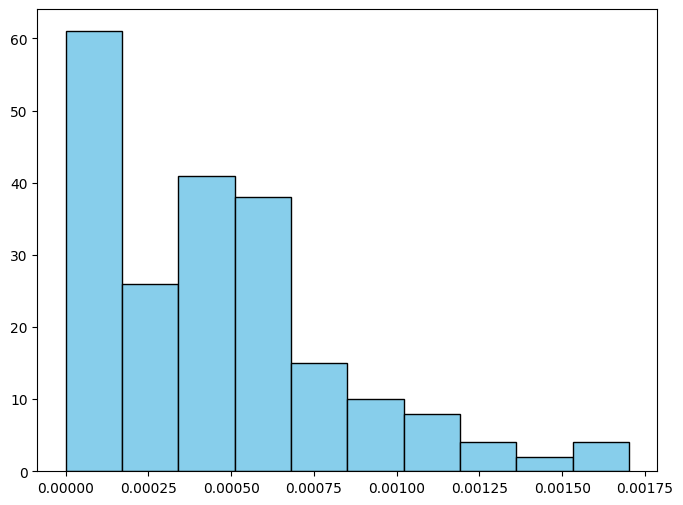

In [48]:
# 히스토그램 그리기
plt.figure(figsize=(8, 6))
plt.hist(coverage, bins=10, color='skyblue', edgecolor='black')

In [49]:
recommended_items = []

for i in range(0, 209):
    test = content_recommender(i, 3, sold_out)
    recommended_items.extend(test[0])


recommended_items = list(map(lambda x: int(x), recommended_items))

In [50]:
from metrics.coverage import get_coverage

n_items = cosine_sim.shape[0]

get_coverage(recommended_items, n_items)

0.8708133971291866

##### 1-2. CountVec + TF-IDF Rank Aggreation

In [51]:
recommended_items = []

for i in range(0, 209):
    test = content_recommender_rank(i, 3, sold_out)
    recommended_items.extend(test[0])


recommended_items = list(map(lambda x: int(x), recommended_items))

In [52]:
from metrics.coverage import get_coverage

n_items = cosine_sim.shape[0]

get_coverage(recommended_items, n_items)

0.7129186602870813

##### 2. Word2Vec

In [73]:
recommended_items = []

for i in range(0, 209):
    test = recommend_similar_items(i, item_embeddings)
    recommended_items.extend(str(test[0]))


recommended_items = list(map(lambda x: int(x), recommended_items))

In [74]:
from metrics.coverage import get_coverage

n_items = len(item_embeddings)

get_coverage(recommended_items, n_items)

0.04784688995215311

#### INFERENCE

##### 1. CountVec + TF-IDF

In [55]:
case_1, _ = content_recommender(1, 3, sold_out)

In [56]:
df[df['product_board_id'].isin(case_1)]

,id,option,option_price,category,gluten_free_tag,high_protein_tag,sugar_free_tag,vegan_tag,ketogenic_tag,title,rate,content,title_with_spaces,title_nouns_list,soup,product_board_id
7,8,,22770,etc,,,,vegan_tag,,[모닐이네하우스] 글루텐프리 100% 쌀 소금빵 5개 세트구성 [모닐이네하우스] ...,4.961538,항상 먹고있는 빵이에요..속편하고 좋아요 자주먹는거에요..그냥먹어도 맛있고버터만 발...,크림 버터 초콜릿 치즈케이크 베이글 쿠키 설탕 스콘,"[크림, 버터, 초콜릿, 치즈케이크, 베이글, 쿠키, 설탕, 스콘]",22770 etc vegan_tag,7
29,30,🍪 선택 🍪,4800,cookie,gluten_free_tag,,,vegan_tag,,"🍪 선택 🍪 비건 글루텐 프리 마들렌 8종 (2P) 구떼 글루텐프리, 오일프리 리얼...",NaN,NaN,쿠키 브라우니 마들렌,"[쿠키, 브라우니, 마들렌]",4800 cookie gluten_free_tag vegan_tag,29
45,46,초코 오트쿠키 (-200원) BEST 슴이쿠키 (-300원) BEST 황치즈 무설탕...,22600,cookie,gluten_free_tag,,,vegan_tag,,초코 오트쿠키 (-200원) BEST 슴이쿠키 (-300원) BEST 황치즈 무설탕...,4.737705,홀리 바치케 대박 맛있어요 무족권임..(얼먹보다 해동한게 풍미 짱이라서 갠적으로 해...,크림 버터 라즈베리 치즈케이크 쿠키 베리 설탕 번,"[크림, 버터, 라즈베리, 치즈케이크, 쿠키, 베리, 설탕, 번]",22600 cookie gluten_free_tag vegan_tag,45


In [57]:
case_2, _ = content_recommender(100, 3, sold_out)

In [58]:
df[df['product_board_id'].isin(case_2)]

,id,option,option_price,category,gluten_free_tag,high_protein_tag,sugar_free_tag,vegan_tag,ketogenic_tag,title,rate,content,title_with_spaces,title_nouns_list,soup,product_board_id
78,79,,5390,etc,,,sugar_free_tag,vegan_tag,,nan 무료체험역시나 적시나 그냥 손으로 뜯어 먹어도 맛있고질 좋은 치아바타(심지...,5.000000,무료체험역시나 적시나 그냥 손으로 뜯어 먹어도 맛있고질 좋은 치아바타(심지어 비건 ...,치아바타 크림 식빵 버터 번,"[치아바타, 크림, 식빵, 버터, 번]",5390 etc sugar_free_tag vegan_tag,78
120,121,,0,etc,gluten_free_tag,,,vegan_tag,,nan 늘 생각나는 맛이에요. 굿굿♡ 이거 진짜 맛있어요…치아바타 좋아하는데다른데...,4.800000,늘 생각나는 맛이에요. 굿굿♡ 이거 진짜 맛있어요…치아바타 좋아하는데다른데거보다 훨...,설탕 치아바타 쿠키 식빵,"[설탕, 치아바타, 쿠키, 식빵]",0 etc gluten_free_tag vegan_tag,120
169,172,초코퍼지 쿠키 땅콩에퐁당 쿠키 말차다미아 쿠키 커피 쿠키,3500,cookie,gluten_free_tag,,,vegan_tag,,초코퍼지 쿠키 땅콩에퐁당 쿠키 말차다미아 쿠키 커피 쿠키 nan 초코가 박혀있지만 ...,4.712644,초코가 박혀있지만 많이 달지 않아서 한번에 다먹었네요맛있게 잘 먹었습니다~ 말차쿠키...,식빵 꿀맛 버터 쿠키 마들렌 설탕,"[식빵, 꿀맛, 버터, 쿠키, 마들렌, 설탕]",3500 cookie gluten_free_tag vegan_tag,169


In [59]:
case_3, _ = content_recommender(200, 3, sold_out)

In [60]:
df[df['product_board_id'].isin(case_3)]

,id,option,option_price,category,gluten_free_tag,high_protein_tag,sugar_free_tag,vegan_tag,ketogenic_tag,title,rate,content,title_with_spaces,title_nouns_list,soup,product_board_id
96,97,구성1 구성2 구성3 라즈베리 초코 그낭시에 4개 패션코코넛 그낭시에 4개,48900,cake,,,,,,구성1 구성2 구성3 라즈베리 초코 그낭시에 4개 패션코코넛 그낭시에 4개 nan ...,4.538462,배송빠르고 배송도빠르고 다음에 또 구매할게용 단거 땡길 때 땡땡얼려있는거 빼 먹...,라즈베리 크림 초콜릿 번,"[라즈베리, 크림, 초콜릿, 번]",48900 cake,96
166,169,,0,etc,,,,,,nan 딸아들이 좋아하는빵이에요맛있다고 즐겨먹네요배송빠르고좋아요 맛도리 자주 시켜...,4.692308,딸아들이 좋아하는빵이에요맛있다고 즐겨먹네요배송빠르고좋아요 맛도리 자주 시켜먹어여 건...,라즈베리 크림,"[라즈베리, 크림]",0 etc,166
175,178,구성1 구성2 구성3 라즈베리 초코 그낭시에 8개 패션코코넛 그낭시에 8개,65200,cake,,,,,,구성1 구성2 구성3 라즈베리 초코 그낭시에 8개 패션코코넛 그낭시에 8개 nan ...,4.615385,일단 크기는 굉장히 작아요 성분이 괜찮아서 구매했는데 저는 그냥 한번 먹어본걸로 만...,라즈베리,[라즈베리],65200 cake,175


##### 2. Word2Vec

In [61]:
recommend_similar_items(3, item_embeddings)

[19, 24, 14]

#### SAVE

In [62]:
import pandas as pd
from datetime import datetime

In [63]:

query_item = df.index.values.repeat(3)

recommended_items = []

for i in range(0, 209):
    test = content_recommender(i, 3, sold_out)
    recommended_items.extend(test[0])


recommended_items = list(map(lambda x: int(x), recommended_items))


score = []

for i in range(0, 209):
    test = content_recommender(i, 3, sold_out)
    score.extend(test[1])


score = list(map(lambda x: float(x), score))


rank = [1, 2, 3]*cosine_sim.shape[0]

recommendation_theme = ['similarity']*cosine_sim.shape[0]*3

model_version = ['bow-1+TF-IDF']*cosine_sim.shape[0]*3

created_at = [datetime.now()]*cosine_sim.shape[0]*3

modified_at = [datetime.now()]*cosine_sim.shape[0]*3

#### 추천 결과 테이블 포맷
- query item은 찜이 눌린 아이템입니다.
- recommendation item은 query 아이템 당 3개를 추출합니다.
- 유사한 recommendation item이 없을 경우 랜덤한 3개의 결과를 추천합니다.
- 포맷에 맞게 데이터프레임을 만듭니다. 

In [64]:
import pandas as pd
from datetime import datetime
data = {
    'query_item': query_item,
    'recommendation_item': recommended_items,
    'score': score,
    'rank': rank,
    'recommendation_theme': recommendation_theme,
    'model_version': model_version,
    'created_at': created_at,
    'modified_at': modified_at
}

recommendation_df = pd.DataFrame(data)


In [65]:
recommendation_df

,query_item,recommendation_item,score,rank,recommendation_theme,model_version,created_at,modified_at
0,0,189,0.729977,1,similarity,bow-1+TF-IDF,2024-11-04 16:54:53.667353,2024-11-04 16:54:53.667353
1,0,32,0.649314,2,similarity,bow-1+TF-IDF,2024-11-04 16:54:53.667353,2024-11-04 16:54:53.667353
2,0,198,0.581581,3,similarity,bow-1+TF-IDF,2024-11-04 16:54:53.667353,2024-11-04 16:54:53.667353
3,1,29,0.533355,1,similarity,bow-1+TF-IDF,2024-11-04 16:54:53.667353,2024-11-04 16:54:53.667353
4,1,7,0.516954,2,similarity,bow-1+TF-IDF,2024-11-04 16:54:53.667353,2024-11-04 16:54:53.667353
...,...,...,...,...,...,...,...,...
622,207,10,0.771317,2,similarity,bow-1+TF-IDF,2024-11-04 16:54:53.667353,2024-11-04 16:54:53.667353
623,207,169,0.711273,3,similarity,bow-1+TF-IDF,2024-11-04 16:54:53.667353,2024-11-04 16:54:53.667353
624,208,3,0.682648,1,similarity,bow-1+TF-IDF,2024-11-04 16:54:53.667353,2024-11-04 16:54:53.667353
625,208,19,0.599424,2,similarity,bow-1+TF-IDF,2024-11-04 16:54:53.667353,2024-11-04 16:54:53.667353


(array([ 88.,  68.,   1.,   5.,  14.,  79., 144., 126.,  56.,  46.]),
 array([0.1       , 0.18341641, 0.26683282, 0.35024922, 0.43366563,
        0.51708204, 0.60049845, 0.68391486, 0.76733126, 0.85074767,
        0.93416408]),
 <BarContainer object of 10 artists>)

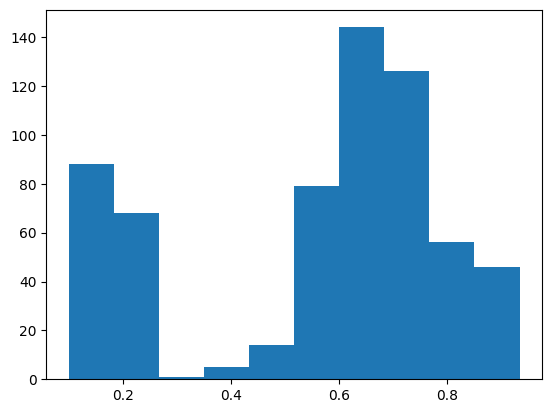

In [66]:
plt.hist(recommendation_df['score'])